# Airbnb price prediction

## Seasonality explotarion
We start exploring the seasonality. We will consider:
* Daily RevPAR from  Airbnb listings
* National holidays in Peru
* Day of the week
* Assumptions on bridge days (long weekends)

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import Airbnb RevPAR data of Chaclacayo - Peru
df_revPAR = pd.read_excel('seasonality_chacla.xlsx', sheet_name='RevPAR')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR
0,2021-08-01,601,Sunday,30,0.672316
1,2021-08-02,520,Monday,31,0.557910
2,2021-08-03,508,Tuesday,31,0.540960
3,2021-08-04,534,Wednesday,31,0.577684
4,2021-08-05,540,Thursday,31,0.586158


In [3]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality_chacla.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
df_holidays['Day']= df_holidays['Date'].dt.day_name()

# Add bridge days:
# * Friday after a holiday in Thursday
for index, row in df_holidays.iterrows():
    if row['Day']=='Thursday' and row['Date'] + pd.Timedelta(days=1) not in df_holidays['Date'].values:
        temp = pd.DataFrame({'Date': [row['Date'] + pd.Timedelta(days=1)], 'Holiday': ['bridge day']})
        temp['CW'] = row['CW']
        temp['Day'] = 'Friday'
        df_holidays = pd.concat([df_holidays, temp], axis=0)
        df_holidays.sort_values(by='Date', inplace=True)
        df_holidays.reset_index(drop=True, inplace=True)
        del temp

df_holidays.head(20)

,Date,Holiday,CW,Day
0,2021-08-30,Santa Rosa de Lima,35,Monday
1,2021-10-08,Combate Naval de Angamos,40,Friday
2,2021-11-01,Día de todos los Santos,44,Monday
3,2021-12-08,Inmaculada Concepción,49,Wednesday
4,2021-12-09,Batalla de Ayacucho,49,Thursday
5,2021-12-10,bridge day,49,Friday
6,2021-12-25,Navidad,51,Saturday
7,2022-01-01,Año Nuevo,52,Saturday
8,2022-04-14,Jueves Santo,15,Thursday
9,2022-04-15,Viernes Santo,15,Friday


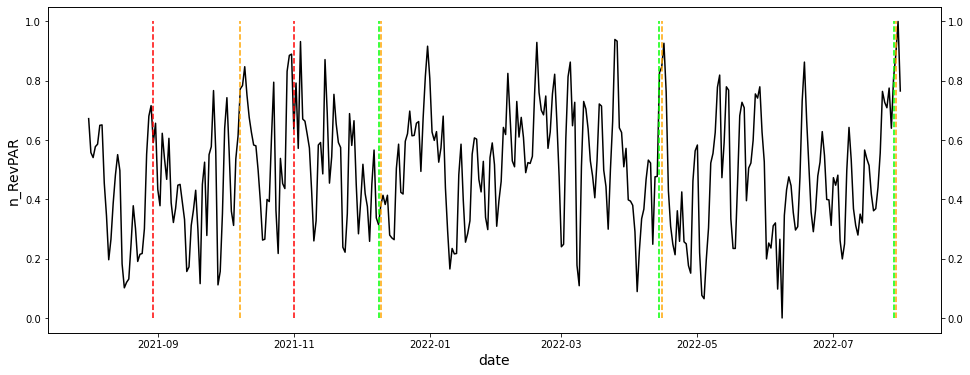

In [24]:
# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(16, 6))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("n_RevPAR", color="black", fontsize=14)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=df_holidays[df_holidays.Day == 'Monday']['Date'], ymin=0, ymax=1, color="r", linestyles='dashed')
ax2.vlines(x=df_holidays[df_holidays.Day == 'Friday']['Date'], ymin=0, ymax=1, color="orange", linestyles='dashed')
ax2.vlines(x=df_holidays[df_holidays.Day == 'Thursday']['Date'], ymin=0, ymax=1, color="lime", linestyles='dashed')

plt.show()

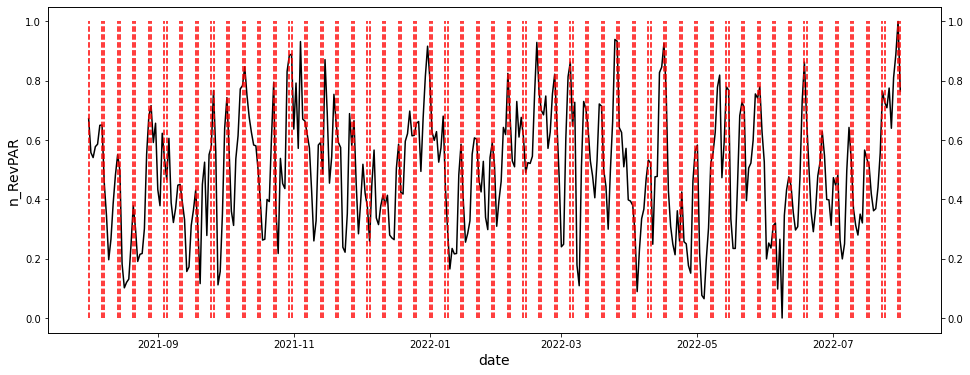

In [23]:
# Now we analyze the effect of weekends
weekends = pd.bdate_range(start="2021-08-01", end="2022-07-31", freq="C", weekmask="Sat Sun")

# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(16, 6))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("n_RevPAR", color="black", fontsize=14)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=weekends, ymin=0, ymax=1, color="r", linestyles='dashed')

plt.show()

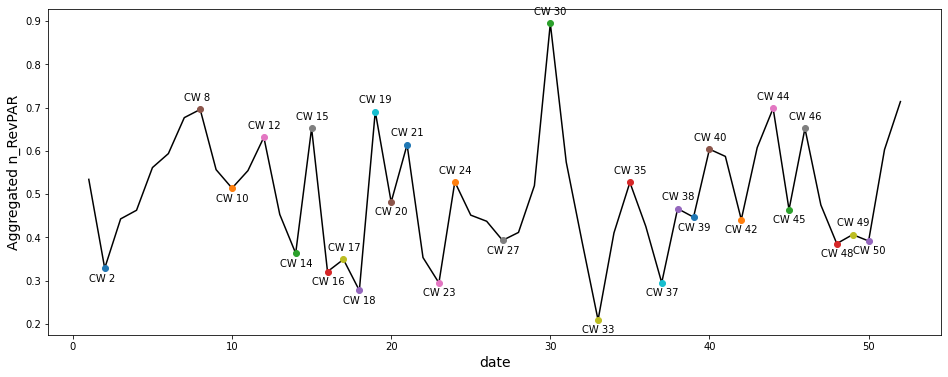

In [76]:
# Calculate aggregated RevPAR per Calendar Week
cw_df = df_revPAR.groupby(df_revPAR.CW)['n_RevPAR'].sum()/7

dates = np.array(cw_df.index.tolist())
returns = np.array(cw_df.values.tolist())

# Calculate the minimas and the maximas
minimas = (np.diff(np.sign(np.diff(returns))) > 0).nonzero()[0] + 1 
maximas = (np.diff(np.sign(np.diff(returns))) < 0).nonzero()[0] + 1

# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(16, 6))

# RevPAR
ax.plot(cw_df, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("Aggregated n_RevPAR", color="black", fontsize=14)

for minima in minimas:
    ax.plot(minima+1, cw_df.iloc[minima], marker="o")
    ax.annotate("CW " + str(minima+1),xy=(minima,cw_df.iloc[minima]-0.03))
    
for maxima in maximas:
    ax.plot(maxima+1, cw_df.iloc[maxima], marker="o")
    ax.annotate("CW " + str(maxima+1),xy=(maxima,cw_df.iloc[maxima]+0.02))

plt.show()

## Observations
* Mondays & Fridays as holiday indicates a long weekend with high RevPAR
* Friday as bridge day don't indicate high RevPAR
* Thrusday as holiday indicates a long weekend and high RevPAR only during the Holy Week and Independence day (due to two days holidays in a row). Also, potentially this could apply for New Year's eve and Christmas.
* Weekends have a relative high RevPAR to their respective months
* Highest RevPAR is found in February & March, during the summer holidays; also then in Holy Week and school holidays. July is an exceptional month, by the end of December. Around October until the mid Nov RevPAR is also up.
* All other CW are either average or below average.

In [2]:
# Import DB
df = pd.read_excel('Guest_Chaclacayo.xlsx', sheet_name='Reservas')

In [3]:
# convert dates column to DateTime
df['R_Date'] = pd.to_datetime(df['R_Date'])
df['R_CheckIn'] = pd.to_datetime(df['R_CheckIn'])
df['R_CheckOut'] = pd.to_datetime(df['R_CheckOut'])

# calculate, how much time in advance the house is booked
df['R_booked'] = df['R_CheckIn'] - df['R_Date']

# Normalize numeric values
df['n_R_Income']=(df['R_Income']-df['R_Income'].min())/(df['R_Income'].max()-df['R_Income'].min())
df['n_R_booked']=(df['R_booked']-df['R_booked'].min())/(df['R_booked'].max()-df['R_booked'].min())

df.tail()

,R_ID,R_Date,R_CheckIn,R_CheckOut,R_NumGuests,R_Shifted,R_Car,R_Pet,R_Income,R_Extra,R_Guest,R_DNI,R_Comments,R_booked,n_R_Income,n_R_booked
37,Chacla0038,2022-04-17,2022-07-08,2022-07-10,8.0,False,True,True,1067.0,100.0,ariana rodriguez paz,73089539.0,no habia declarado a su perro pero luego depos...,82 days,0.040383,1.000000
38,Chacla0039,2022-04-23,2022-07-12,2022-07-24,7.0,False,False,False,4695.0,NaN,maria bravo,25621179.0,"peruana radicada en Georgia, problematica y re...",80 days,0.780339,0.975610
39,Chacla0040,2022-06-28,2022-07-25,2022-07-31,12.0,False,True,False,5772.0,NaN,angel soto bartolo,15353615.0,peruano radicado en California,27 days,1.000000,0.329268
40,Chacla0041,2022-07-11,2022-08-01,2022-08-04,8.0,False,False,False,1571.0,NaN,natali evangelista,41855749.0,NaN,21 days,0.143178,0.256098
41,Chacla0042,2022-06-15,2022-08-05,2022-08-07,8.0,False,True,False,1319.0,NaN,carolina ledesma,7886928.0,peruana vive en Largo Florida\npago a traves ...,51 days,0.091781,0.621951


Text(0, 0.5, 'R_booked')

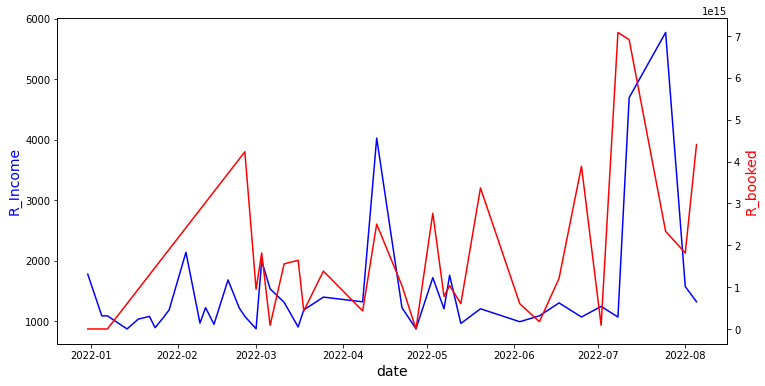

In [4]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df['R_CheckIn'], df['R_Income'], color="blue", label="R_Income")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("R_Income", color="blue", fontsize=14)

ax2=ax.twinx()
ax2.plot(df['R_CheckIn'], df['R_booked'], color="red", label="R_booked")
ax2.set_ylabel("R_booked", color="red", fontsize=14)


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

df2 = df[['R_CheckIn','R_Income']]
df2.set_index('R_CheckIn', inplace=True)
df2.head()

,R_Income
R_CheckIn,
2021-12-31,1775.0
2022-01-05,1086.0
2022-01-07,1086.0
2022-01-14,869.0
2022-01-18,1032.0


In [10]:
decompose_result_mult = seasonal_decompose(df2, model="additive")

trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid

decompose_result_mult.plot();

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None